In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math

from dataset import get_dataset
from metrics import Metrics

Matplotlib is building the font cache; this may take a moment.


In [2]:
_, _, data_np = get_dataset(name="electricity", window_len=1, cxt_len=1, pred_len=1)

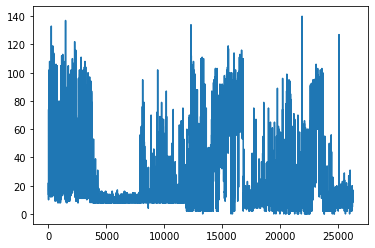

In [3]:
plt.plot(data_np[0])

In [4]:
pred_len = 100
window_len = 400
sample_len = 800

# only train with the first few observations of each time series
train_ds = torch.tensor(data_np[:, :sample_len-pred_len])
test_ds = torch.tensor(data_np[:, sample_len-pred_len-window_len:sample_len])

In [5]:
train_mean = []
train_sd = []
for i in range(train_ds.shape[0]):
    sample_mean = torch.mean(train_ds[i])
    sample_sd = torch.std(train_ds[i], unbiased = True)
    train_mean.append(sample_mean)
    train_sd.append(sample_sd)
    train_ds[i] = (train_ds[i] - sample_mean) / sample_sd
    test_ds[i] = (test_ds[i] - sample_mean) / sample_sd

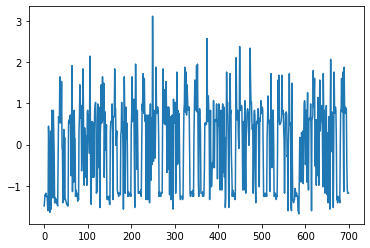

In [6]:
plt.plot(train_ds[0].detach().numpy())

In [7]:
def create_inout_sequences(input_data, window_len, pred_len = 1):
    L = len(input_data)
    x = torch.empty([L-window_len, window_len ,1])
    y = torch.empty([L-window_len ,1])
    for i in range(L-window_len):
        x[i, :, 0] = input_data[i:i+window_len]
        y[i, 0] = input_data[i+window_len:i+window_len+pred_len]
    return x, y

In [8]:
class LSTM(nn.Module):
    def __init__(self, num_outputs = 2, input_size = 1, hidden_size = 50, num_layers = 1):
        super(LSTM, self).__init__()
        
        self.num_outputs = num_outputs
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=.5)
        
        self.fc = nn.Linear(hidden_size, num_outputs)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).cuda()
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).cuda()
        # Propagate input through LSTM
        output, (h_out, _) = self.lstm(x, (h_0, c_0))
        out = output[:, -1, :]
        out = self.fc(out)
        out[:, 1] = torch.log(1 + torch.exp(out[:, 1])) # variance
        
        return out

In [9]:
def NLLloss(y, mean, var):
    """ Negative log-likelihood loss function. """
    return (torch.log(var) + torch.pow(y - mean, 2)/var).sum()

In [10]:
num_epochs = 30
learning_rate = 0.002
batch_size = 100

input_size = 1
hidden_size = 300
num_layers = 2
num_outputs = 2

lstm = LSTM(num_outputs, input_size, hidden_size, num_layers).cuda()
lstm.train()

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(len(train_ds)):
        optimizer.zero_grad()
        loss = 0
        train_x, train_y = create_inout_sequences(train_ds[i], window_len)
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        num_batch = math.ceil(train_x.shape[0] / batch_size)
        for j in range(num_batch):
            outputs = lstm(train_x[(j * batch_size) : ((j+1) * batch_size), :, :])
            loss += NLLloss(train_y[(j * batch_size) : ((j+1) * batch_size), :].squeeze(1), outputs[:, 0], outputs[:, 1])
        loss /= train_x.shape[0]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        #print("Epoch: %d, series: %d, loss: %1.5f" % (epoch, i, loss.item()))
    print("Epoch: %d, total loss: %1.5f" % (epoch, total_loss))

Epoch: 0, total loss: -257.73856
Epoch: 1, total loss: -339.25226
Epoch: 2, total loss: -373.55072
Epoch: 3, total loss: -392.31096
Epoch: 4, total loss: -419.12197
Epoch: 5, total loss: -445.52862
Epoch: 6, total loss: -457.03761
Epoch: 7, total loss: -479.69423
Epoch: 8, total loss: -498.86052
Epoch: 9, total loss: -507.97970
Epoch: 10, total loss: -519.02216
Epoch: 11, total loss: -505.38061
Epoch: 12, total loss: -512.98068
Epoch: 13, total loss: -542.61233
Epoch: 14, total loss: -555.96029
Epoch: 15, total loss: -559.21367
Epoch: 16, total loss: -567.14832
Epoch: 17, total loss: -554.61113
Epoch: 18, total loss: -576.56469
Epoch: 19, total loss: -576.11505
Epoch: 20, total loss: -588.84976
Epoch: 21, total loss: -594.93856
Epoch: 22, total loss: -602.80133
Epoch: 23, total loss: -596.62226
Epoch: 24, total loss: -609.93497
Epoch: 25, total loss: -577.45102
Epoch: 26, total loss: -586.72430
Epoch: 27, total loss: -603.80875
Epoch: 28, total loss: -613.43345
Epoch: 29, total loss: -

In [13]:
lstm.eval()

pred_mean = np.empty([test_ds.shape[0], pred_len])
pred_var = np.empty([test_ds.shape[0], pred_len])

for i in range(len(test_ds)):
    test_x, test_y = create_inout_sequences(test_ds[i], window_len)
    test_x = test_x.cuda()
    test_y = test_y.cuda()
    outputs = lstm(test_x)
    pred_mean[i, :] = outputs[:, 0].cpu().detach().numpy()
    pred_var[i, :] = outputs[:, 1].cpu().detach().numpy()

In [14]:
with open('test_pred.npy', 'wb') as f:
    np.save(f, pred_mean)
    np.save(f, pred_var)

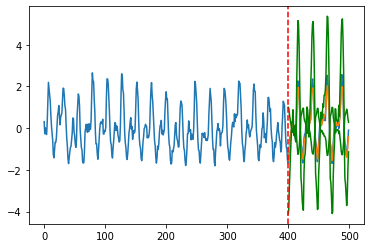

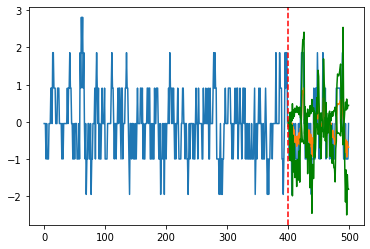

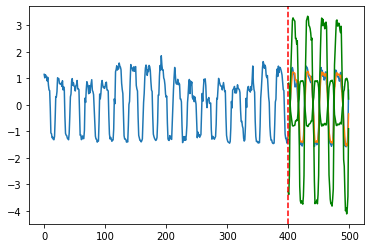

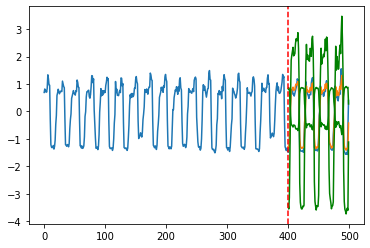

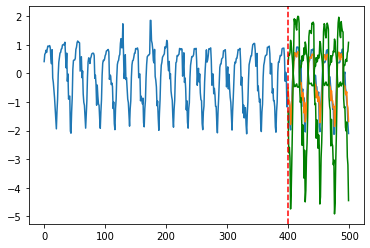

In [15]:
ind = 45
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 146
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 199
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 272
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 304
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()
